<a href="https://colab.research.google.com/github/cyndwith/DeepGC/blob/master/SRGAN/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.layers as tkl

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.0.0,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).
',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples

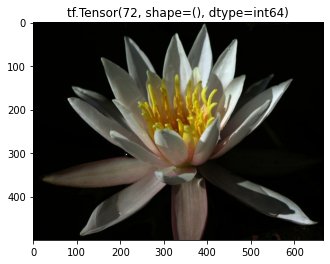

In [39]:
splits = ("train[:80]", "train[:10]", "train[:10]")

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'oxford_flowers102', split=splits,
    with_info=True, as_supervised=True)

print(metadata)
print(raw_train)
print(raw_validation)
print(raw_test)

get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(1):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

<DatasetV1Adapter shapes: ((96, 96, 3), (384, 384, 3)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((96, 96, 3), (384, 384, 3)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((96, 96, 3), (384, 384, 3)), types: (tf.float32, tf.float32)>


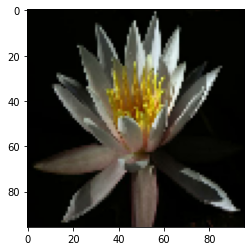

In [40]:
SCALE = 4
def resize_dataset(image, label):
  hr_image = tf.cast(image, tf.float32)
  hr_image = tf.image.resize(hr_image, (384, 384))
  hr_image = hr_image / 255
  lr_image = tf.image.resize(image, (96, 96))
  lr_image = lr_image / 255
  return lr_image, hr_image 

# Apply this function to each item in the dataset using the map method:
flower_train      = raw_train.map(resize_dataset)
flower_validation = raw_validation.map(resize_dataset)
flower_test       = raw_test.map(resize_dataset)
print(flower_train)
print(flower_validation)
print(flower_test)

for image, label in flower_train.take(1):
  plt.figure()
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
  

In [41]:
# Now shuffle and batch the data.
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 1000

flower_train_batches      = flower_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
flower_validation_batches = flower_validation.batch(BATCH_SIZE, drop_remainder=True)
flower_test_batches       = flower_test.batch(BATCH_SIZE, drop_remainder=True)

print(flower_train_batches)
print(flower_validation_batches)
print(flower_test_batches)


<DatasetV1Adapter shapes: ((4, 96, 96, 3), (4, 384, 384, 3)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((4, 96, 96, 3), (4, 384, 384, 3)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((4, 96, 96, 3), (4, 384, 384, 3)), types: (tf.float32, tf.float32)>


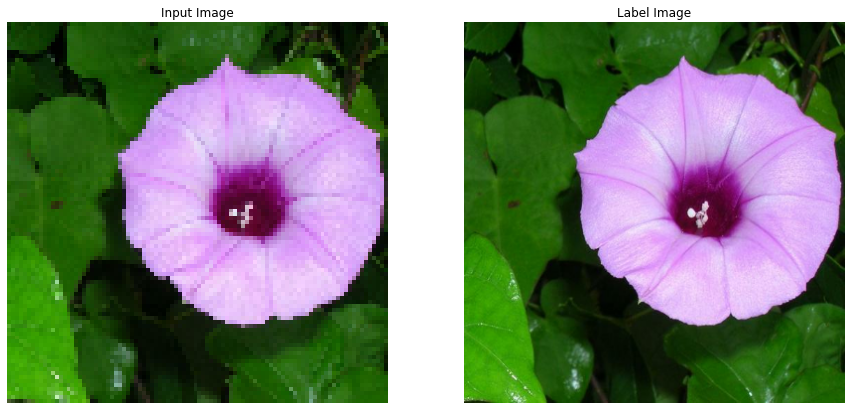

In [42]:
from IPython.display import clear_output

# show sample image from dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Label Image', 'Predicted Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, label in flower_train_batches.take(1):
  display([image[0], label[0]])
  

In [0]:
import tensorflow.keras.layers as tkl

IMAGE_SIZE  = 384
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

def srgan_gen(input_size=(int(IMAGE_SIZE/4), int(IMAGE_SIZE/4), 3)):
  inputs = tkl.Input(input_size)
  n = tkl.Conv2D(64, 3, padding='same', activation='relu')(inputs)
  temp = n

  for i in range(16):
    n_tmp = tkl.Conv2D(64, 3, padding='same')(n)
    n_tmp = tkl.BatchNormalization()(n_tmp)
    n_tmp = tkl.ReLU()(n_tmp)
    n_tmp = tkl.Conv2D(64, 3, padding='same')(n_tmp)
    n_tmp = tkl.BatchNormalization()(n_tmp)
    n_tmp = tkl.Add()([n, n_tmp])
    n = n_tmp
  
  n = tkl.Conv2D(64, 3, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.Add()([n, temp])

  n = tkl.Conv2D(256, 3, padding='same')(n)
  n = tkl.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(n)

  n = tkl.Conv2D(256, 3, padding='same')(n)
  n = tkl.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(n)

  n = tkl.Conv2D(3, 1, padding='same', activation='tanh')(n)

  model = tf.keras.Model(inputs=inputs, outputs=n, name='srgan_gen')
  #model.summary()
  return model

def srgan_dis(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
  inputs = tkl.Input(input_shape)
  n = tkl.Conv2D(64, 4, strides=2, padding='same')(inputs)
  n = tkl.LeakyReLU()(n)
  
  n = tkl.Conv2D(64 * 2, 4, strides=2, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 4, 4, strides=2, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 8, 4, strides=2, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 16, 4, strides=2, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 32, 4, strides=2, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 16, 4, strides=1, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 8, 4, strides=1, padding='same')(n)
  nx = tkl.BatchNormalization()(n)
  
  n = tkl.Conv2D(64 * 2, 1, strides=1, padding='same')(nx)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 2, 3, strides=1, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  n = tkl.LeakyReLU()(n)
  n = tkl.Conv2D(64 * 8, 3, strides=1, padding='same')(n)
  n = tkl.BatchNormalization()(n)
  
  n = tkl.Add()([n, nx])
  n = tkl.LeakyReLU()(n)
  n = tkl.Flatten()(n)
  n = tkl.Dense(1)(n)
  
  model = tf.keras.Model(inputs=inputs, outputs=n, name='srgan_dis')
  #model.summary()
  return model

#G = srgan_gen()
#D = srgan_dis()  

In [0]:
import os
import time
from IPython.display import clear_output

def mse(pred, ref):
  pred = tf.cast(pred, dtype = tf.float32)
  ref = tf.cast(ref, dtype=tf.float32)
  loss = tf.reduce_mean(tf.square(tf.subtract(pred, ref)))
  return loss

checkpoint_dir = '/content/srgan_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(optimizer=model_optimizer,model=G)

model_save_path = '/content/srgan_model/'


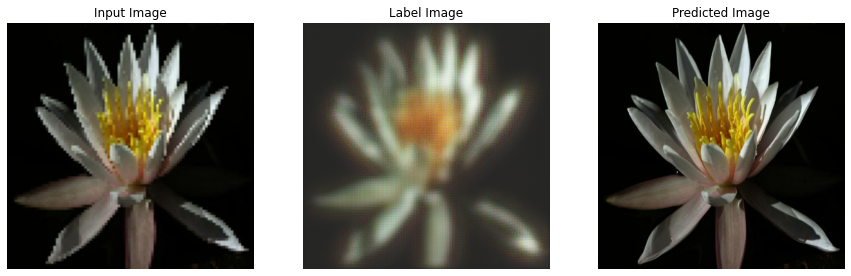

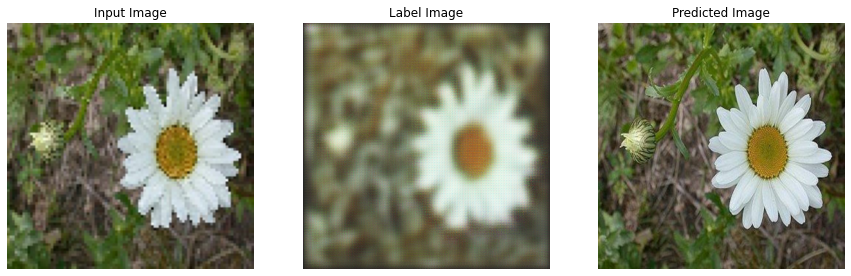

Epoch: 0/4, time: 621.491s g_loss:0.020


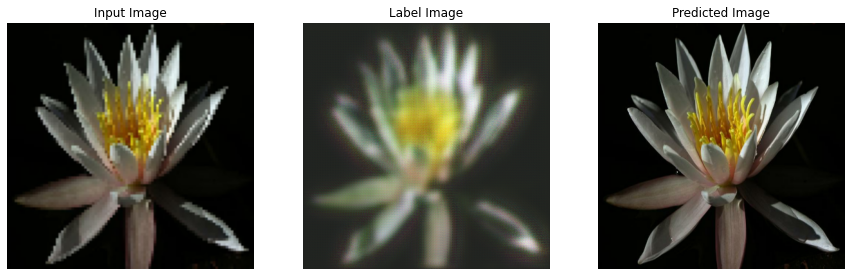

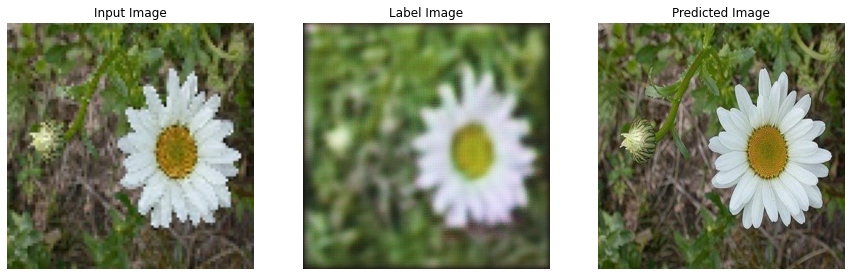

Epoch: 1/4, time: 623.053s g_loss:0.010
tf.Tensor(1.7756852e-07, shape=(), dtype=float32)
tf.Tensor(1.41266e-07, shape=(), dtype=float32)
tf.Tensor(1.7335736e-07, shape=(), dtype=float32)
tf.Tensor(1.3899418e-07, shape=(), dtype=float32)
tf.Tensor(1.3809192e-07, shape=(), dtype=float32)
tf.Tensor(1.2748576e-07, shape=(), dtype=float32)
tf.Tensor(1.3056119e-07, shape=(), dtype=float32)
tf.Tensor(1.2752591e-07, shape=(), dtype=float32)
tf.Tensor(9.3794604e-08, shape=(), dtype=float32)
tf.Tensor(1.5663387e-07, shape=(), dtype=float32)
tf.Tensor(1.6099041e-07, shape=(), dtype=float32)
tf.Tensor(1.3632592e-07, shape=(), dtype=float32)
tf.Tensor(1.3538575e-07, shape=(), dtype=float32)
tf.Tensor(1.5080268e-07, shape=(), dtype=float32)
tf.Tensor(1.299315e-07, shape=(), dtype=float32)
tf.Tensor(1.5630381e-07, shape=(), dtype=float32)
tf.Tensor(1.0786033e-07, shape=(), dtype=float32)
tf.Tensor(1.4613168e-07, shape=(), dtype=float32)
tf.Tensor(1.4604447e-07, shape=(), dtype=float32)
tf.Tensor(1.5

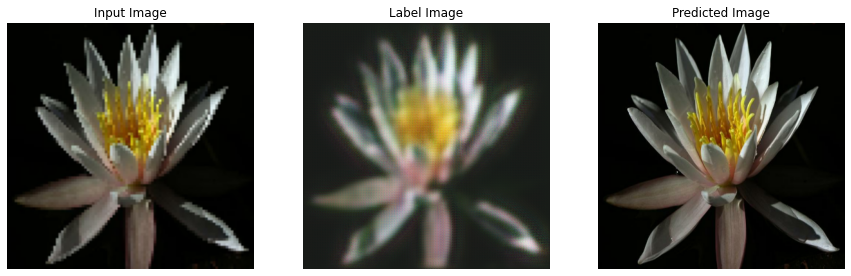

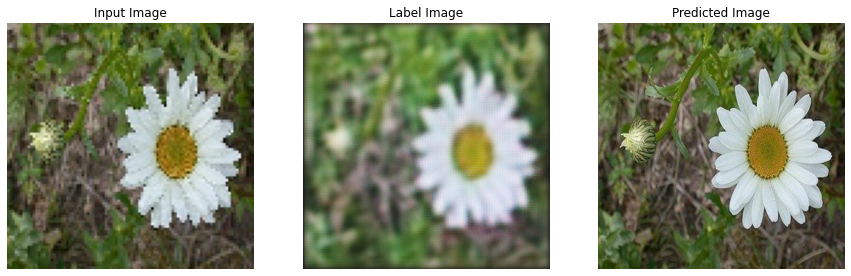

Epoch: 0/4, time: 2412.557s g_loss(mse:0.014, vgg:0.000, adv:0.001) d_loss: 14.482


In [45]:
#import tensorlayer as tl
def test(model, image, label):
  output = model(image)
  display([image[0], label[0], output[0]])

def srgan_train(n_epoch):
  lr_shape = (96, 96, 3)
  hr_shape = (384, 384, 3)
  G = srgan_gen(lr_shape)
  D = srgan_dis(hr_shape)

  VGG19 = tf.keras.applications.VGG19(include_top=False)
  #VGG19.summary()

  gen_optimizer = tf.keras.optimizers.Adam(1e-4)
  dis_optimizer = tf.keras.optimizers.Adam(1e-4)
  
  # train the generator
  for epoch in range(2):
    start_time = time.time()
    for lr_image, hr_image in flower_train_batches:
      with tf.GradientTape() as tape:
        fake_image = G(lr_image)
        loss = mse(fake_image, hr_image)
      grad = tape.gradient(loss, G.trainable_weights)
      gen_optimizer.apply_gradients(zip(grad, G.trainable_weights))
      #print('Epoch: {}/{}, time: {:.3f}s g_loss:{:.3f}'.format(epoch, n_epoch, time.time() - start_time, loss))
    if (epoch + 1)% 1 == 0:
      for image, label in flower_test_batches:
        test(G, image, label)
    print('Epoch: {}/{}, time: {:.3f}s g_loss:{:.3f}'.format(epoch, n_epoch, time.time() - start_time, loss))
  
  # training gen and dis networks
  for epoch in range(n_epoch):
    start_time = time.time()
    step = 0
    for lr_image, hr_image in flower_train_batches:
      step = step + 1
      with tf.GradientTape(persistent=True) as tape:
        fake_image = G(lr_image)
        dis_fake   = D(fake_image)
        dis_real   = D(hr_image)
        features_fake = VGG19(fake_image)
        features_real = VGG19(hr_image)
        #d_real_loss = tl.cost.sigmoid_cross_entropy(logits_real, tf.ones_like(dis_real))
        #d_fake_loss = tl.cost.sigmoid_cross_entropy(logits_fake, tf.zeros_like(dis_fake))
        d_real_loss = tf.abs(tf.reduce_mean(tf.keras.losses.binary_crossentropy(dis_real, tf.ones_like(dis_real))))
        d_fake_loss = tf.abs(tf.reduce_mean(tf.keras.losses.binary_crossentropy(dis_fake, tf.zeros_like(dis_fake))))
        d_loss = d_real_loss + d_fake_loss
        #gen_loss = 1e-3 * tl.cost.sigmoid_cross_entropy(dis_fake, tf.ones_like(dis_fake))
        gen_loss = 1e-3 * tf.abs(tf.reduce_mean(tf.keras.losses.binary_crossentropy(dis_fake, tf.ones_like(dis_fake))))
        mse_loss = mse(fake_image, hr_image)
        vgg_loss = 2e-6 * mse(features_fake, features_real)
        g_loss = mse_loss + vgg_loss + gen_loss
      grad = tape.gradient(g_loss, G.trainable_weights)
      gen_optimizer.apply_gradients(zip(grad, G.trainable_weights))
      grad = tape.gradient(d_loss, D.trainable_weights)
      dis_optimizer.apply_gradients(zip(grad, D.trainable_weights))
      #print('Epoch: {}/{}, time: {:.3f}s g_loss(mse:{:.3f}, vgg:{:.3f}, adv:{:.3f}) d_loss: {:.3f}'.format(epoch, 
      #       n_epoch, time.time() - start_time, mse_loss, vgg_loss, gen_loss, d_loss))
    
    if (epoch + 1) % 1 == 0:
      for image, label in flower_test_batches:
        test(G, image, label)
    print('Epoch: {}/{}, time: {:.3f}s g_loss(mse:{:.3f}, vgg:{:.3f}, adv:{:.3f}) d_loss: {:.3f}'.format(epoch, 
             n_epoch, time.time() - start_time, mse_loss, vgg_loss, gen_loss, d_loss))
    return G
          
srgan_model = srgan_train(100)

In [0]:
for image, label in flower_train_batches:
  test(srgan_model, image, label)  

In [0]:
# Convert Keras model to TF Lite format.
print(tf.__version__)
converter = tf.lite.TFLiteConverter.from_keras_model(srgan_model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

In [0]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

In [0]:
import random

test_image = []
test_label = []
for image, label in flower_test_batches.take(1):
  test_image = image
  test_label = label

def show_model_predictions(tflite_model, dataset=flower_test_batches, num=1):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  prediction_image = []
  # Run predictions on every image in the "test" dataset.
  for test_image, test_label in dataset.take(1):
    # Pre-processing: add batch dimension to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image[0], axis=0).astype(np.float32)
    # print(test_image)
    # print(test_label)
    # test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)
    # Run inference.
    interpreter.invoke()
    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    prediction_image.append(output())

  if len(prediction_image) == 0:
    print('No prediction found!')
  else:
    for image, label in dataset.take(1):
      pred = prediction_image[0]
      display([image[0], label[0], pred[0]])


# float model prediction
show_model_predictions(tflite_float_model, flower_test_batches)

# quantized model prediction
show_model_predictions(tflite_quantized_model, flower_test_batches)

In [0]:
# Save the float model to file to the Downloads directory
f = open('/content/drive/My Drive/DeepGC/UNet/myUNet_float.tflite', "wb")
f.write(tflite_float_model)
f.close()

# Save the quantized model to file to the Downloads directory
f = open('/content/drive/My Drive/DeepGC/UNet/myUNet_quant.tflite', "wb")
f.write(tflite_quantized_model)
f.close()